In [48]:
#Loading Dependencies 
import pandas as pd
import numpy as np
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import GridSearchCV

In [3]:
#Importing DATA
data1 = pd.read_csv("data_exercise_40.csv", usecols = range(1,120), header = 0)
data1 = data1.fillna(0)
s1 = pd.read_csv("data_exercise_40.csv", usecols = range(120,121) , header = 0)

#Split dataset
seed = 0
test_size = .2
X_train, X_test, y_train, y_test = train_test_split(data1, s1, test_size=test_size, random_state=seed)

In [4]:
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 35.04%


kappa score:   0.26582062209903845


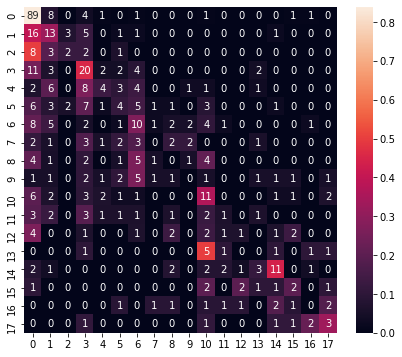

In [31]:
#confusion matrix and kappa score for testing set

cm = confusion_matrix(y_test, predictions)

def plot_confusion_matrix(cm, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g')

plot_confusion_matrix(cm)

print( "kappa score:  ", cohen_kappa_score(y_test, predictions))

kappa score:   1.0


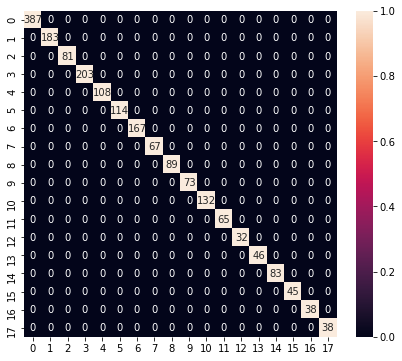

In [30]:
#confusion matrix and kappa score for training set

y_train_pred = model.predict(X_train)
predictions1 = [round(value) for value in y_train_pred]


cm1 = confusion_matrix(y_train, predictions1)

def plot_confusion_matrix(cm1, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm1 = cm1
    if normalized:
        norm_cm1 = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm1, annot=cm1, fmt='g')

plot_confusion_matrix(cm1)

print( "kappa score:  ", cohen_kappa_score(y_train, predictions1))

In [10]:
#hyperparamter tuning


from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [42]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="merror",
            early_stopping_rounds=50,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)



SCORE:                                                 
0.21721311475409835                                    
SCORE:                                                                             
0.21721311475409835                                                                
SCORE:                                                                             
0.21721311475409835                                                                
SCORE:                                                                             
0.21721311475409835                                                                
SCORE:                                                                             
0.21721311475409835                                                                
SCORE:                                                                             
0.21721311475409835                                                                
SCORE:                                          

0.21721311475409835                                                                 
SCORE:                                                                              
0.21721311475409835                                                                 
SCORE:                                                                              
0.21721311475409835                                                                 
SCORE:                                                                              
0.21721311475409835                                                                 
100%|██████████| 100/100 [02:14<00:00,  1.35s/trial, best loss: -0.21721311475409835]


In [43]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.5145320903837066, 'gamma': 5.707464680261381, 'max_depth': 10.0, 'min_child_weight': 3.0, 'reg_alpha': 131.0, 'reg_lambda': 0.8800866088550799}


In [50]:
param = {'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

model_tuned = XGBClassifier(param)
model_tuned.fit(X_train, y_train.values.ravel())
# make predictions for test data
y_pred = model_tuned.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 35.04%


In [49]:
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 92.1min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 98.7min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}